Processing Image: 2.TIF, Mask: 2_mask.TIF
Original Image Dimensions: (7151, 7941, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 262, 262, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/

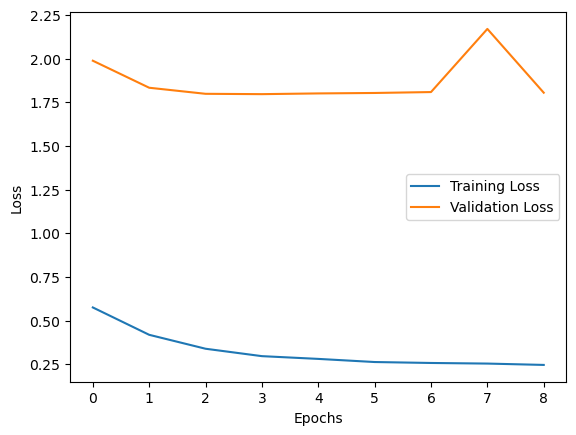

In [6]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt

# Function to split an image into tiles
def split_image_into_tiles(image_path, mask_path, tile_size):
    img = tifffile.imread(image_path)
    mask = tifffile.imread(mask_path)

    mask = mask[:, :, 0] if len(mask.shape) == 3 else mask
    print(f"Original Image Dimensions: {img.shape}")
    tiles_img = []
    tiles_mask = []

    for x in range(0, img.shape[1], tile_size):
        for y in range(0, img.shape[0], tile_size):
            tile_img = img[y:y+tile_size, x:x+tile_size, :] if len(img.shape) == 3 else img[y:y+tile_size, x:x+tile_size]
            tile_mask = mask[y:y+tile_size, x:x+tile_size]

            # Resize to the desired size
            tile_img = cv2.resize(tile_img, (size, size))
            tile_mask = cv2.resize(tile_mask, (size, size))
            tile_mask = (tile_mask > 0).astype(np.uint8)

            tiles_img.append(tile_img)
            tiles_mask.append(tile_mask)

    # Calculate the number of tiles needed to form a perfect square
    num_tiles = len(tiles_img)
    perfect_square_size = int(np.ceil(np.sqrt(num_tiles)))
    total_tiles_needed = perfect_square_size**2
    num_tiles_to_add = total_tiles_needed - num_tiles

    # Pad the list of tiles with zeros
    for _ in range(num_tiles_to_add):
        tiles_img.append(np.zeros((size, size, img.shape[2]), dtype=np.uint8))
        tiles_mask.append(np.zeros((size, size), dtype=np.uint8))

    tiles_img = np.array(tiles_img)
    tiles_mask = np.array(tiles_mask)

    return tiles_img, tiles_mask

# Function to load data
def load_data(image_dir, mask_dir, tile_size):
    images = []
    masks = []

    # Sort filenames to ensure consistency
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for image_filename in image_filenames:
        if image_filename.endswith(".TIF"):
            mask_filename = image_filename.replace(".TIF", "_mask.TIF")

            if mask_filename in mask_filenames:
                image_path = os.path.join(image_dir, image_filename)
                mask_path = os.path.join(mask_dir, mask_filename)

                print(f"Processing Image: {image_filename}, Mask: {mask_filename}")

                img, mask = split_image_into_tiles(image_path, mask_path, tile_size)

                images.extend(img)
                masks.extend(mask)

    return np.array(images), np.array(masks)

# Define paths
image_dir = "datasets/images"
mask_dir = "datasets/masks"

# Tile size
tile_size = 256
size = 256
# Load data
tiles_img, tiles_mask = load_data(image_dir, mask_dir, tile_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tiles_img, tiles_mask, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Reshape masks
y_train = y_train.reshape(y_train.shape + (1,))
y_val = y_val.reshape(y_val.shape + (1,))
y_test = y_test.reshape(y_test.shape + (1,))

# Define DenseNet U-Net model
def densenet_unet_model(input_size=(size, size, 3), freeze_encoder=True):
    # Use DenseNet121 as the backbone
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_size)

    # Encoder
    encoder_output = densenet_base.get_layer('conv5_block16_concat').output
    
    # Freeze the layers in the encoder
    if freeze_encoder:
        for layer in densenet_base.layers:
            layer.trainable = False

    # Decoder
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(encoder_output)
    x = Concatenate()([x, densenet_base.get_layer('conv4_block24_concat').output])
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = Concatenate()([x, densenet_base.get_layer('conv3_block12_concat').output])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = Concatenate()([x, densenet_base.get_layer('conv2_block6_concat').output])
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = Concatenate()([x, densenet_base.get_layer('conv1/conv').output])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer
    output = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Resize the output to match the size of the ground truth masks
    output = tf.image.resize(output, (size, size), method='bilinear')

    model = Model(inputs=densenet_base.input, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

# Create the DenseNet U-Net model
densenet_unet_model = densenet_unet_model(input_size=(size, size, 3), freeze_encoder=True)

# Learning rate schedule
def lr_schedule(epoch):
    initial_learning_rate = 0.0001
    decay = 0.9
    if epoch % 10 == 0 and epoch:
        return initial_learning_rate * decay
    return initial_learning_rate

# Use LearningRateScheduler callback to adjust learning rate dynamically
lr_scheduler = LearningRateScheduler(lr_schedule)

# Increased data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

# callback function to stop overfitting the model
checkpointer = ModelCheckpoint("best_weight_unet_densenet_311223.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks = [
    earlyStopping,
    checkpointer
]

# Train the model on the training set
history = densenet_unet_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=100, validation_data=(X_val, y_val), callbacks=[lr_scheduler] + callbacks)

# Evaluate the model on the test set
test_loss, test_accuracy = densenet_unet_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Save the model
densenet_unet_model.save('forest_detection_model_densenet_unet_311223.h5')

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


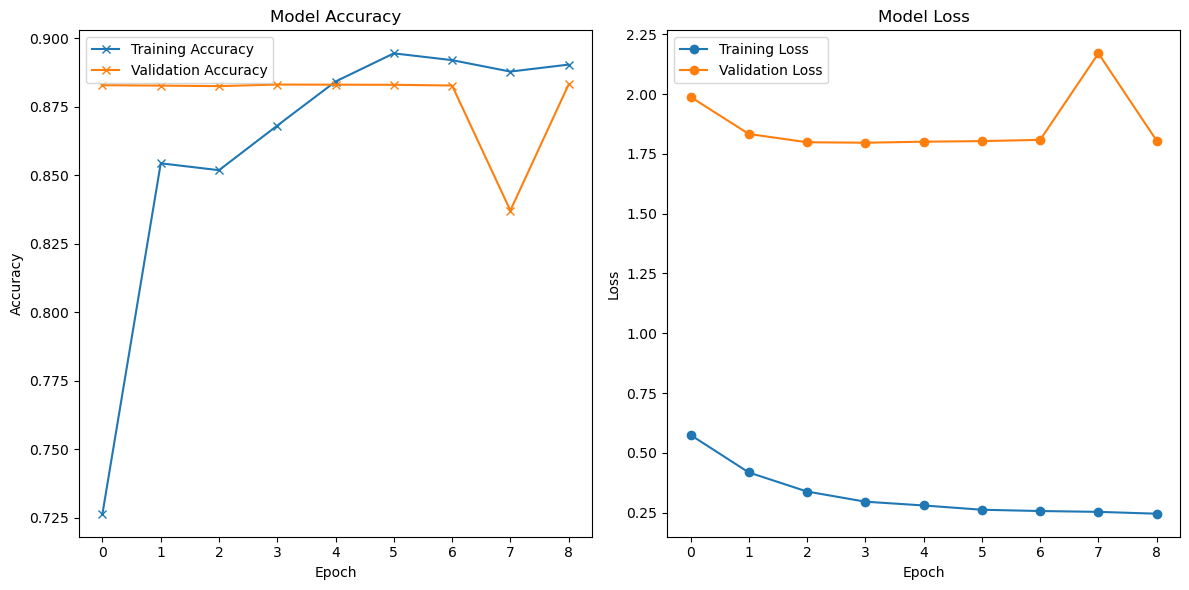

In [7]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", marker='x')
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='x')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", marker='o')
plt.plot(history.history["val_loss"], label="Validation Loss", marker='o')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Load the saved model
loaded_model = tf.keras.models.load_model('best_weight_unet_densenet_311223.h5')

# Predict on the test set
y_pred = loaded_model.predict(X_test)

# Threshold predictions to obtain binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Flatten the arrays for computing metrics
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()

# Calculate metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


6/6 [==============================] - 42s 5s/step
Accuracy: 0.8950
F1 Score: 0.8791
Precision: 0.9838
Recall: 0.7945


In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('best_weight_unet_densenet_311223.h5')

# Predictions on the test set
y_pred = loaded_model.predict(X_test)

# Threshold the predictions to get binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Flatten the arrays for metrics calculation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()

# Calculate and print accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)
print(f'Accuracy: {accuracy:.4f}')

# Calculate and print F1 score
f1 = f1_score(y_test_flat, y_pred_flat)
print(f'F1 Score: {f1:.4f}')

# Calculate and print precision
precision = precision_score(y_test_flat, y_pred_flat)
print(f'Precision: {precision:.4f}')

# Calculate and print recall
recall = recall_score(y_test_flat, y_pred_flat)
print(f'Recall: {recall:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate mean intersection over union (mIoU)
intersection = np.sum(np.logical_and(y_test_flat, y_pred_flat))
union = np.sum(np.logical_or(y_test_flat, y_pred_flat))
miou = intersection / union
print(f'Mean Intersection over Union (mIoU): {miou:.4f}')


6/6 [==============================] - 16s 2s/step
Accuracy: 0.8950
F1 Score: 0.8791
Precision: 0.9838
Recall: 0.7945
Confusion Matrix:
[[6053152   74060]
 [1164843 4504425]]
Mean Intersection over Union (mIoU): 0.7843
